## CSCA5642 - Week 4 Assignment

### 1.Background
The data used in this project comes from Kaggle. It is a set of 10,000 tweets classified as either talking about natural disasters or not (binary classification). The challenge is to build a natural language model to classify these tweets as either referencing real natural disasters or not.

## 2. Exploratory Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers, Model, Input, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

%matplotlib inline

In [2]:
train = pd.read_csv("nlp-getting-started/train.csv")
test = pd.read_csv("nlp-getting-started/test.csv")

In [3]:
train = train[["text", "target"]]
test = test[["id", "text"]]

In [4]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isna().sum()

text      0
target    0
dtype: int64

<Axes: title={'center': 'Distribution of classes'}, xlabel='target'>

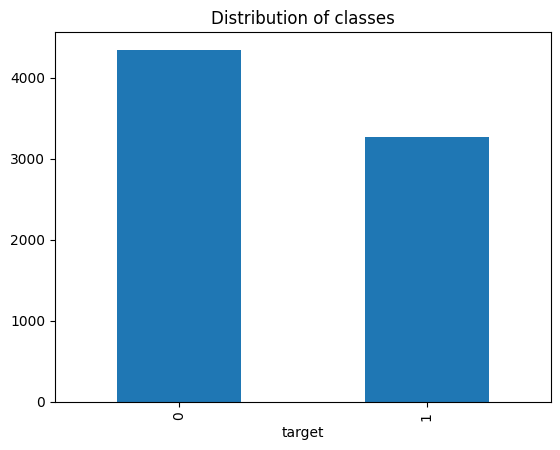

In [6]:
train["target"].value_counts().plot(kind="bar", title="Distribution of classes")

### 3. Model building

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train["text"], train["target"], test_size=0.2)

In [8]:
# create dummy model for baseline
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
print(f"Train accuracy: {dummy.score(X_train, y_train)}")
print(f"Val accuracy: {dummy.score(X_val, y_val)}")

Train accuracy: 0.49507389162561577
Val accuracy: 0.5167432698621143


In [9]:
def generate_model(max_vocab_size, max_seq_len, embed_dim, lstm_units: int = 64, dropout_rate: float = 0, learning_rate: float = 1e-3, dense_units: int = 10):
    model = Sequential(
        [
            layers.Embedding(
                input_dim=max_vocab_size,
                output_dim=embed_dim,
                input_length=max_seq_len,
            ),
            layers.Bidirectional(
                layers.LSTM(lstm_units, return_sequences=True),
            ),
            layers.GlobalMaxPool1D(),
            layers.Dense(dense_units, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation="sigmoid")
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", "precision", "recall"]
    )

    model.summary()
    return model

In [10]:
def get_vectorizer(text, max_vocab_size, max_seq_len):
    vectorizer = layers.TextVectorization(
        max_tokens=max_vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len
    )
    vectorizer.adapt(text.values)
    return vectorizer

def generate_inputs(X_train, X_val, max_vocab_size, max_seq_len):
    vectorizer = get_vectorizer(X_train, max_vocab_size, max_seq_len)
    X_train_seq = vectorizer(X_train).numpy()
    X_val_seq = vectorizer(X_val)
    return (X_train_seq, X_val_seq)

In [11]:
def plot_loss_over_epochs(history):
    plt.figure(figsize=(7,5))
    plt.plot(range(1, history.params["epochs"]+1), history.history["loss"], label="train loss")
    plt.plot(range(1, history.params["epochs"]+1), history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.show()

In [12]:
X_train_1, X_val_1 = generate_inputs(X_train, X_val, 20000, 100)
model_1 = generate_model(20000, 100, 128, dropout_rate=0.2)
history_1 = model_1.fit(
    X_train_1,
    y_train,
    validation_data=(X_val_1, y_val),
    epochs=5
)

/Users/jaifadia/.pyenv/versions/csca5642/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6160 - loss: 0.6450 - precision: 0.7327 - recall: 0.1660 - val_accuracy: 0.7938 - val_loss: 0.4531 - val_precision: 0.8222 - val_recall: 0.6707
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8839 - loss: 0.3126 - precision: 0.8943 - recall: 0.8257 - val_accuracy: 0.7768 - val_loss: 0.5111 - val_precision: 0.7447 - val_recall: 0.7402
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9580 - loss: 0.1368 - precision: 0.9643 - recall: 0.9366 - val_accuracy: 0.7301 - val_loss: 0.7551 - val_precision: 0.6685 - val_recall: 0.7523
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9837 - loss: 0.0591 - precision: 0.9868 - recall: 0.9751 - val_accuracy: 0.7531 - val_loss: 0.8069 - val_precision: 0.7173 - val_recall: 0.7130
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9909 - loss: 0.0379 - precision: 0.9917 - recall: 0.9869 - val_accuracy: 0.7124 - val_loss: 1.

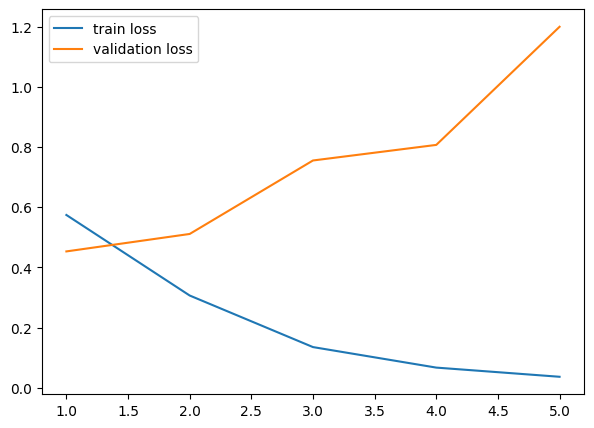

In [13]:
plot_loss_over_epochs(history_1)

In [14]:
X_train_2, X_val_2 = generate_inputs(X_train, X_val, 10000, 100)
model_2 = generate_model(10000, 100, 64, dropout_rate=0.2)
history_2 = model_2.fit(
    X_train_2,
    y_train,
    validation_data=(X_val_2, y_val),
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5885 - loss: 0.6714 - precision: 0.5327 - recall: 0.1444 - val_accuracy: 0.7833 - val_loss: 0.4759 - val_precision: 0.8502 - val_recall: 0.6088
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8383 - loss: 0.4039 - precision: 0.8729 - recall: 0.7338 - val_accuracy: 0.7932 - val_loss: 0.4681 - val_precision: 0.8183 - val_recall: 0.6737
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9077 - loss: 0.2604 - precision: 0.9343 - recall: 0.8470 - val_accuracy: 0.7695 - val_loss: 0.5565 - val_precision: 0.7426 - val_recall: 0.7190
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9360 - loss: 0.1956 - precision: 0.9567 - recall: 0.8907 - val_accuracy: 0.7584 - val_loss: 0.6922 - val_precision: 0.7207 - val_recall: 0.7251
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9576 - loss: 0.1325 - precision: 0.9666 - recall: 0.9338 - val_accuracy: 0.7065 - val_loss: 0.

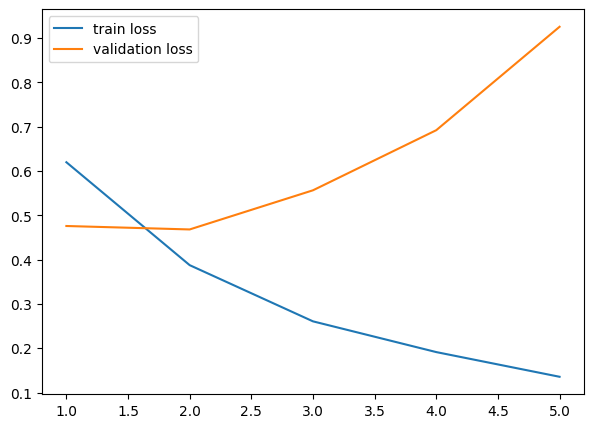

In [15]:
plot_loss_over_epochs(history_2)

In [16]:
X_train_3, X_val_3 = generate_inputs(X_train, X_val, 10000, 100)
model_3 = generate_model(10000, 100, 64, dropout_rate=0.5)
history_3 = model_3.fit(
    X_train_3,
    y_train,
    validation_data=(X_val_3, y_val),
    epochs=5
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5762 - loss: 0.6693 - precision: 0.4847 - recall: 0.0679 - val_accuracy: 0.7781 - val_loss: 0.5277 - val_precision: 0.8293 - val_recall: 0.6163
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8297 - loss: 0.4552 - precision: 0.8535 - recall: 0.7225 - val_accuracy: 0.7827 - val_loss: 0.4965 - val_precision: 0.8004 - val_recall: 0.6662
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9054 - loss: 0.3388 - precision: 0.9101 - recall: 0.8613 - val_accuracy: 0.7814 - val_loss: 0.5258 - val_precision: 0.7891 - val_recall: 0.6782
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9412 - loss: 0.2646 - precision: 0.9339 - recall: 0.9269 - val_accuracy: 0.7472 - val_loss: 0.5679 - val_precision: 0.6916 - val_recall: 0.7553
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9533 - loss: 0.2213 - precision: 0.9361 - recall: 0.9550 - val_accuracy: 0.7400 - val_loss: 0.

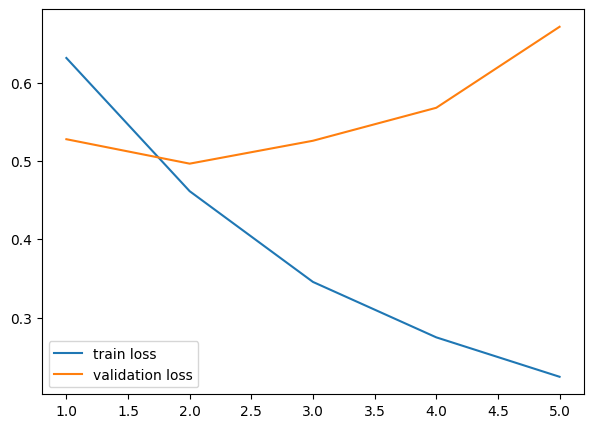

In [17]:
plot_loss_over_epochs(history_3)

In [22]:
X_train_4, X_val_4 = generate_inputs(X_train, X_val, 10000, 100)
model_4 = generate_model(10000, 100, 64, dropout_rate=0.5, dense_units=4)
history_4 = model_4.fit(
    X_train_4,
    y_train,
    validation_data=(X_val_4, y_val),
    epochs=5
)

/Users/jaifadia/.pyenv/versions/csca5642/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5715 - loss: 0.6760 - precision: 0.2933 - recall: 0.0137 - val_accuracy: 0.6756 - val_loss: 0.6086 - val_precision: 0.5857 - val_recall: 0.8671
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6873 - loss: 0.5573 - precision: 0.6771 - recall: 0.5563 - val_accuracy: 0.7919 - val_loss: 0.4919 - val_precision: 0.8075 - val_recall: 0.6843
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8103 - loss: 0.4472 - precision: 0.7515 - recall: 0.8490 - val_accuracy: 0.7991 - val_loss: 0.4983 - val_precision: 0.8167 - val_recall: 0.6934
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8560 - loss: 0.3658 - precision: 0.7857 - recall: 0.9156 - val_accuracy: 0.7433 - val_loss: 0.5748 - val_precision: 0.6757 - val_recall: 0.7870
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8572 - loss: 0.3333 - precision: 0.7782 - recall: 0.9336 - val_accuracy: 0.7682 - val_loss: 0.

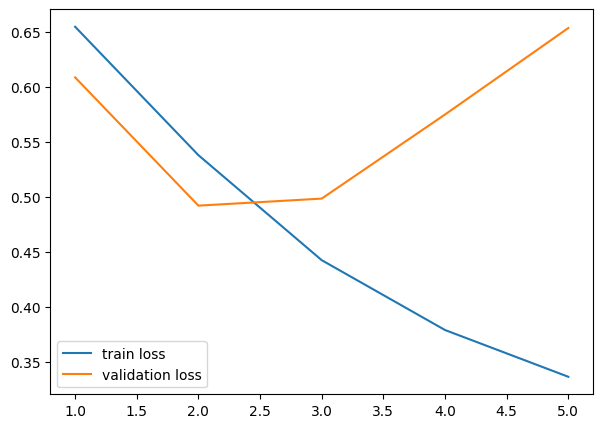

In [23]:
plot_loss_over_epochs(history_4)

In [24]:
# make predictions
vectorizer = get_vectorizer(X_train, 10000, 100)
X_test = vectorizer(test["text"].values).numpy()
pred = model_4.predict(X_test)
pred = pred > 0.5

test["target"] = pred.astype("int")
test[["id", "target"]].to_csv("pred.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### 4 & 5. Results & Analysis, Conclusions
I used a bidirectional LSTM network so that I could retain tokens early on in the text to add context to later tokens, while also being able to use later context to contextualize earlier tokens. This is important because both earlier and later tokens can have an impact on whether or not the user is actually talking about a natural disaster.

Results for model 4:
1. On the validation set, the model performed better than the dummy model meaning that it does perform better than random chance
2. Initially the model was overfitting because of the large LSTM units and large number of dense units in the only dense layer; reducing both and increasing the dropout rate greatly reduced the overfitting of the model
3. The number of epochs required to train this model is not high; it converges to a reasonable training and testing accuracy (~84%, ~75%) within the first few epochs